In [7]:
import numpy as np
import pandas as pd

In [8]:
target_data = pd.read_csv('/content/drive/MyDrive/DATASET/Train-1542865627584.csv')
beneficiary = pd.read_csv('/content/drive/MyDrive/DATASET/Train_Beneficiarydata-1542865627584.csv')
inpatient = pd.read_csv('/content/drive/MyDrive/DATASET/Train_Inpatientdata-1542865627584.csv')
outpatient = pd.read_csv('/content/drive/MyDrive/DATASET/Train_Outpatientdata-1542865627584.csv')


In [9]:
claims = pd.concat([inpatient, outpatient], ignore_index=True)


In [10]:
claims_df = claims.merge(beneficiary, on='BeneID', how='left')


In [11]:
claims_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558211 entries, 0 to 558210
Data columns (total 54 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   BeneID                           558211 non-null  object 
 1   ClaimID                          558211 non-null  object 
 2   ClaimStartDt                     558211 non-null  object 
 3   ClaimEndDt                       558211 non-null  object 
 4   Provider                         558211 non-null  object 
 5   InscClaimAmtReimbursed           558211 non-null  int64  
 6   AttendingPhysician               556703 non-null  object 
 7   OperatingPhysician               114447 non-null  object 
 8   OtherPhysician                   199736 non-null  object 
 9   AdmissionDt                      40474 non-null   object 
 10  ClmAdmitDiagnosisCode            145899 non-null  object 
 11  DeductibleAmtPaid                557312 non-null  float64
 12  Di

In [12]:
# -------------------
# 1. Setup
# -------------------
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# -------------------
# 2. Load Data
# -------------------
df = claims_df.copy()

# Convert dates safely
for col in ["ClaimStartDt", "ClaimEndDt", "AdmissionDt", "DischargeDt", "DOB", "DOD"]:
    df[col] = pd.to_datetime(df[col], errors="coerce")

# -------------------
# 3. Claim-level Feature Engineering (20+ features)
# -------------------
df_features = pd.DataFrame()
df_features["ClaimID"] = df["ClaimID"]

# 1. Claim Duration (days)
df_features["Claim_Duration"] = (df["ClaimEndDt"] - df["ClaimStartDt"]).dt.days

# 2. Length of Stay (inpatient only)
df_features["LOS"] = (df["DischargeDt"] - df["AdmissionDt"]).dt.days

# 3. Claim Amount reimbursed
df_features["Claim_Amount"] = df["InscClaimAmtReimbursed"]

# 4. Deductible Paid
df_features["DeductiblePaid"] = df["DeductibleAmtPaid"]

# 5. Payment Ratio
df_features["Pay_Ratio"] = df["InscClaimAmtReimbursed"] / (
    df["InscClaimAmtReimbursed"] + df["DeductibleAmtPaid"] + 1
)

# 6. Num Diagnosis Codes
diag_cols = [c for c in df.columns if "DiagnosisCode" in c]
df_features["Num_Diags"] = df[diag_cols].notna().sum(axis=1)

# 7. Num Procedure Codes
proc_cols = [c for c in df.columns if "ClmProcedureCode" in c]
df_features["Num_Procs"] = df[proc_cols].notna().sum(axis=1)

# 8. Age of Beneficiary at Claim Start
df_features["Patient_Age"] = (
    (df["ClaimStartDt"] - df["DOB"]).dt.days / 365.25
).astype(float)

# 9. Death During Claim
df_features["Death_During_Claim"] = (
    (df["DOD"].notna())
    & (df["DOD"] >= df["ClaimStartDt"])
    & (df["DOD"] <= df["ClaimEndDt"])
).astype(int)

# 10. Admission vs Claim Start gap
df_features["Admission_Claim_Gap"] = (
    df["AdmissionDt"] - df["ClaimStartDt"]
).dt.days

# 11. Discharge vs Claim End gap
df_features["Discharge_Claim_Gap"] = (
    df["ClaimEndDt"] - df["DischargeDt"]
).dt.days

# 12. Was Inpatient? and 13. Was Outpatient?
df_features["Is_Inpatient"] = (df['InscClaimAmtReimbursed'].notna()).astype(int)
df_features["Is_Outpatient"] = (~df['InscClaimAmtReimbursed'].notna()).astype(int)


# 14. Gender of Beneficiary
df_features["Gender"] = LabelEncoder().fit_transform(df["Gender"].astype(str))

# 15. State Encoded
df_features["State"] = LabelEncoder().fit_transform(df["State"].astype(str))

# 16. Chronic Condition Count
chronic_cols = [c for c in df.columns if "ChronicCond" in c]
df_features["Chronic_Count"] = df[chronic_cols].sum(axis=1)

# 17. Renal Disease Indicator
df_features["Renal_Disease"] = df["RenalDiseaseIndicator"].map({"Y": 1, "N": 0})

# 18. Num Physicians Involved
df_features["Num_Physicians"] = df[
    ["AttendingPhysician", "OperatingPhysician", "OtherPhysician"]
].notna().sum(axis=1)

# 19. Attending vs Operating Physician Same?
df_features["Attending_Operating_Same"] = (
    df["AttendingPhysician"] == df["OperatingPhysician"]
).astype(int)

# 20. Claim Month
df_features["Claim_Month"] = df["ClaimStartDt"].dt.month

# 21. Claim Year
df_features["Claim_Year"] = df["ClaimStartDt"].dt.year

# 22. Weekend Admission
df_features["Weekend_Admission"] = (
    df["AdmissionDt"].dt.dayofweek.isin([5, 6])
).astype(int)

# -------------------
# ✅ Final Claim-Level Feature Dataset (no target variable)
# -------------------
print(df_features.head())

    ClaimID  Claim_Duration   LOS  Claim_Amount  DeductiblePaid  Pay_Ratio  \
0  CLM46614               6   6.0         26000          1068.0   0.960508   
1  CLM66048               2   2.0          5000          1068.0   0.823859   
2  CLM68358               3   3.0          5000          1068.0   0.823859   
3  CLM38412               8   8.0          5000          1068.0   0.823859   
4  CLM63689              17  17.0         10000          1068.0   0.903424   

   Num_Diags  Num_Procs  Patient_Age  Death_During_Claim  ...  Is_Outpatient  \
0         10          0    66.277892                   0  ...              0   
1          4          1    66.663929                   0  ...              0   
2          7          0    66.710472                   0  ...              0   
3         10          1    94.959617                   0  ...              0   
4         10          1    71.367556                   0  ...              0   

   Gender  State  Chronic_Count  Renal_Disease  Nu

In [13]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558211 entries, 0 to 558210
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ClaimID                   558211 non-null  object 
 1   Claim_Duration            558211 non-null  int64  
 2   LOS                       40474 non-null   float64
 3   Claim_Amount              558211 non-null  int64  
 4   DeductiblePaid            557312 non-null  float64
 5   Pay_Ratio                 557312 non-null  float64
 6   Num_Diags                 558211 non-null  int64  
 7   Num_Procs                 558211 non-null  int64  
 8   Patient_Age               558211 non-null  float64
 9   Death_During_Claim        558211 non-null  int64  
 10  Admission_Claim_Gap       40474 non-null   float64
 11  Discharge_Claim_Gap       40474 non-null   float64
 12  Is_Inpatient              558211 non-null  int64  
 13  Is_Outpatient             558211 non-null  i

In [14]:
import pandas as pd

# Assuming your dataset is in df
df = df_features.copy()

# 1️⃣ Fill LOS, Admission_Claim_Gap, Discharge_Claim_Gap with 0
df["LOS"] = df["LOS"].fillna(0)
df["Admission_Claim_Gap"] = df["Admission_Claim_Gap"].fillna(0)
df["Discharge_Claim_Gap"] = df["Discharge_Claim_Gap"].fillna(0)

# 2️⃣ Drop rows where any other column has NaN
df = df.dropna()

# ✅ Check result
print(df.isna().sum())  # should all be 0
print(df.shape)


ClaimID                     0
Claim_Duration              0
LOS                         0
Claim_Amount                0
DeductiblePaid              0
Pay_Ratio                   0
Num_Diags                   0
Num_Procs                   0
Patient_Age                 0
Death_During_Claim          0
Admission_Claim_Gap         0
Discharge_Claim_Gap         0
Is_Inpatient                0
Is_Outpatient               0
Gender                      0
State                       0
Chronic_Count               0
Renal_Disease               0
Num_Physicians              0
Attending_Operating_Same    0
Claim_Month                 0
Claim_Year                  0
Weekend_Admission           0
dtype: int64
(109498, 23)


# **RULES FOR THIS POTENTIAL FLAGS**

Unusually long claim duration → duration > 60 days.

Short LOS with high claim → LOS ≤ 2 but Claim_Amount > 20,000.

Very high deductible ratio → DeductiblePaid / Claim_Amount > 0.8.

Low payment ratio → Pay_Ratio < 0.2.

Too many diagnoses → Num_Diags > 10.

Too many procedures → Num_Procs > 8.

Unrealistic patient age → Patient_Age < 0 or > 110.

Death during claim with outpatient → Death_During_Claim = 1 and Is_Outpatient = 1.

Admission far after claim start → Admission_Claim_Gap > 10.

Discharge gap abnormal → Discharge_Claim_Gap < 0 or > 30.

High inpatient claims with 0 LOS → Is_Inpatient = 1 and LOS = 0.

Outpatient claim with long LOS → Is_Outpatient = 1 and LOS > 5.

Gender encoding invalid → Gender not in {0,1}.

State encoding invalid → State < 1 or State > 50.

High chronic count but low claim → Chronic_Count ≥ 5 and Claim_Amount < 500.

Renal disease but low claim → Renal_Disease = 1 and Claim_Amount < 200.

Too many physicians → Num_Physicians > 5.

Attending and operating same but many procedures → Attending_Operating_Same = 1 and Num_Procs > 10.

In [15]:
import numpy as np

# Start with all 0 (not fraud)
df["PotentialFraud"] = 0

# 1. Unusually long claim duration
df.loc[df["Claim_Duration"] > 60, "PotentialFraud"] = 1

# 2. Short LOS with high claim
df.loc[(df["LOS"] <= 2) & (df["Claim_Amount"] > 20000), "PotentialFraud"] = 1

# 3. Very high deductible ratio
df.loc[(df["Claim_Amount"] > 0) &
       (df["DeductiblePaid"] / df["Claim_Amount"] > 0.8), "PotentialFraud"] = 1

# 4. Low payment ratio
df.loc[df["Pay_Ratio"] < 0.2, "PotentialFraud"] = 1

# 5. Too many diagnoses
df.loc[df["Num_Diags"] > 10, "PotentialFraud"] = 1

# 6. Too many procedures
df.loc[df["Num_Procs"] > 8, "PotentialFraud"] = 1

# 7. Unrealistic patient age
df.loc[(df["Patient_Age"] < 0) | (df["Patient_Age"] > 110), "PotentialFraud"] = 1

# 8. Death during claim with outpatient
df.loc[(df["Death_During_Claim"] == 1) & (df["Is_Outpatient"] == 1), "PotentialFraud"] = 1

# 9. Admission far after claim start
df.loc[df["Admission_Claim_Gap"] > 10, "PotentialFraud"] = 1

# 10. Discharge gap abnormal
df.loc[(df["Discharge_Claim_Gap"] < 0) | (df["Discharge_Claim_Gap"] > 30), "PotentialFraud"] = 1

# 11. High inpatient claims with 0 LOS
df.loc[(df["Is_Inpatient"] == 1) & (df["LOS"] == 0), "PotentialFraud"] = 1

# 12. Outpatient claim with long LOS
df.loc[(df["Is_Outpatient"] == 1) & (df["LOS"] > 5), "PotentialFraud"] = 1

# 13. Gender encoding invalid
df.loc[~df["Gender"].isin([0,1]), "PotentialFraud"] = 1

# 14. State encoding invalid
df.loc[(df["State"] < 1) | (df["State"] > 50), "PotentialFraud"] = 1

# 15. High chronic count but low claim
df.loc[(df["Chronic_Count"] >= 5) & (df["Claim_Amount"] < 500), "PotentialFraud"] = 1

# 16. Renal disease but low claim
df.loc[(df["Renal_Disease"] == 1) & (df["Claim_Amount"] < 200), "PotentialFraud"] = 1

# 17. Too many physicians
df.loc[df["Num_Physicians"] > 5, "PotentialFraud"] = 1

# 18. Attending and operating same but many procedures
df.loc[(df["Attending_Operating_Same"] == 1) & (df["Num_Procs"] > 10), "PotentialFraud"] = 1

# ✅ Check summary
print(df["PotentialFraud"].value_counts())


PotentialFraud
1    101165
0      8333
Name: count, dtype: int64


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109498 entries, 4 to 558157
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ClaimID                   109498 non-null  object 
 1   Claim_Duration            109498 non-null  int64  
 2   LOS                       109498 non-null  float64
 3   Claim_Amount              109498 non-null  int64  
 4   DeductiblePaid            109498 non-null  float64
 5   Pay_Ratio                 109498 non-null  float64
 6   Num_Diags                 109498 non-null  int64  
 7   Num_Procs                 109498 non-null  int64  
 8   Patient_Age               109498 non-null  float64
 9   Death_During_Claim        109498 non-null  int64  
 10  Admission_Claim_Gap       109498 non-null  float64
 11  Discharge_Claim_Gap       109498 non-null  float64
 12  Is_Inpatient              109498 non-null  int64  
 13  Is_Outpatient             109498 non-null  int64 

In [17]:
import pandas as pd

# Load your DataFrame 'df' here.
# Assuming 'df' is already loaded with your data.

# Drop non-numeric columns and the ClaimID as they can't be correlated
features_to_check = df.drop(columns=['ClaimID'])

# Calculate the correlation of all features with the 'PotentialFraud' target
correlations = features_to_check.corrwith(features_to_check['PotentialFraud']).sort_values(ascending=False)

# Display the correlations. The top value (after the target itself) is the likely culprit.
print("Correlation with PotentialFraud:")
print(correlations)

Correlation with PotentialFraud:
PotentialFraud              1.000000
Chronic_Count               0.098011
Pay_Ratio                   0.085409
Claim_Year                  0.033108
Claim_Month                 0.022747
Admission_Claim_Gap         0.012820
Death_During_Claim          0.001227
Gender                     -0.000950
Patient_Age                -0.001756
Discharge_Claim_Gap        -0.004204
State                      -0.005767
Attending_Operating_Same   -0.039946
Num_Physicians             -0.071348
Claim_Duration             -0.124825
Weekend_Admission          -0.466601
Num_Diags                  -0.569736
Claim_Amount               -0.601747
Num_Procs                  -0.608035
LOS                        -0.627780
DeductiblePaid             -0.895330
Is_Inpatient                     NaN
Is_Outpatient                    NaN
Renal_Disease                    NaN
dtype: float64


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [18]:
import pandas as pd

# Assuming 'df' is your original DataFrame
df_cleaned = df.drop(columns=['DeductiblePaid'])

# Drop non-numeric columns and the ClaimID
features_to_check = df_cleaned.drop(columns=['ClaimID'])

# Calculate the new correlations
new_correlations = features_to_check.corrwith(features_to_check['PotentialFraud']).sort_values(ascending=False)

print("New Correlations with PotentialFraud:")
print(new_correlations)

New Correlations with PotentialFraud:
PotentialFraud              1.000000
Chronic_Count               0.098011
Pay_Ratio                   0.085409
Claim_Year                  0.033108
Claim_Month                 0.022747
Admission_Claim_Gap         0.012820
Death_During_Claim          0.001227
Gender                     -0.000950
Patient_Age                -0.001756
Discharge_Claim_Gap        -0.004204
State                      -0.005767
Attending_Operating_Same   -0.039946
Num_Physicians             -0.071348
Claim_Duration             -0.124825
Weekend_Admission          -0.466601
Num_Diags                  -0.569736
Claim_Amount               -0.601747
Num_Procs                  -0.608035
LOS                        -0.627780
Is_Inpatient                     NaN
Is_Outpatient                    NaN
Renal_Disease                    NaN
dtype: float64


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [19]:
df.head(50)

,ClaimID,Claim_Duration,LOS,Claim_Amount,DeductiblePaid,Pay_Ratio,Num_Diags,Num_Procs,Patient_Age,Death_During_Claim,...,Gender,State,Chronic_Count,Renal_Disease,Num_Physicians,Attending_Operating_Same,Claim_Month,Claim_Year,Weekend_Admission,PotentialFraud
4,CLM63689,17,17.0,10000,1068.0,0.903424,10,1,71.367556,0,...,1,38,17,1.0,2,0,8,2009,0,0
17,CLM54477,1,1.0,4000,1068.0,0.789110,10,0,51.597536,0,...,1,41,15,1.0,1,0,6,2009,1,0
23,CLM60246,3,3.0,5000,1068.0,0.823859,10,0,84.049281,0,...,0,5,18,1.0,1,0,7,2009,1,0
28,CLM48802,5,5.0,5000,1068.0,0.823859,10,0,54.488706,0,...,0,26,16,1.0,2,0,4,2009,0,0
34,CLM32146,6,6.0,20000,1068.0,0.949262,11,2,86.677618,0,...,1,48,15,1.0,2,0,1,2009,1,1
35,CLM82202,9,6.0,20000,1068.0,0.949262,11,2,86.677618,0,...,1,48,15,1.0,2,0,1,2009,1,1
36,CLM33470,6,6.0,5000,1068.0,0.823859,10,0,83.115674,0,...,0,42,17,1.0,1,0,1,2009,0,0
37,CLM58670,5,5.0,11000,1068.0,0.911426,9,1,83.597536,0,...,0,42,17,1.0,2,1,7,2009,0,0
40,CLM44765,1,1.0,8000,1068.0,0.882126,5,1,71.080082,0,...,1,26,16,1.0,2,0,3,2009,0,0
43,CLM78387,4,4.0,2000,1068.0,0.651678,9,0,76.676249,0,...,1,22,15,1.0,1,0,12,2009,0,0


# **XGBOOST**

In [31]:
import pandas as pd
import numpy as np
import io
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# --- Step 1: Create a Hybrid Dataset (Real + Synthetic) ---

np.random.seed(42)

# Raw data provided by the user, stored in a string
raw_user_data = """ClaimID Claim_Duration LOS Claim_Amount DeductiblePaid Pay_Ratio Num_Diags Num_Procs Patient_Age Death_During_Claim Is_Inpatient Is_Outpatient Gender State Chronic_Count Renal_Disease Num_Physicians Attending_Operating_Same Claim_Month Claim_Year Weekend_Admission PotentialFraud
4CLM6368917 17.0 10000 1068.0 0.903424 3 4 24 1 0 1 3 81 7 1.0 2 08 2009 0 0
17CLM544771 1.0 400 1068.0 0.789110 1 1 0 0 1 0 1 4 1 1.0 1 06 2009 1 0
23CLM602463 3.0 500 1068.0 0.823859 1 0 0 0 1 0 0 5 18 1 1.0 1 07 2009 1 0
28CLM488025 5.0 500 1068.0 0.823859 1 0 0 0 1 0 0 2 6 1 1.0 2 04 2009 0 0
34CLM321466 6.0 2000 0 1068.0 0.949262 1 1 28 0 0 1 4 8 15 1.0 2 01 2009 1 1
35CLM822029 6.0 20000 1068.0 0.949262 1 1 28 0 0 1 4 8 15 1.0 2 01 2009 1 1
36CLM334706 6.0 500 1068.0 0.823859 1 0 0 0 1 0 0 4 2 17 1.0 1 01 2009 0 0
37CLM586705 5.0 11000 1068.0 0.911426 9 1 83 0 0 1 4 2 17 1.0 2 17 2009 0 0
40CLM447651 1.0 800 1068.0 0.882126 5 1 71 0 0 1 2 6 16 1.0 2 03 2009 0 0
43CLM783874 4.0 2000 1068.0 0.651678 9 0 76 0 0 1 2 2 15 1.0 1 01 2009 0 0
46CLM440632 2.0 300 1068.0 0.737282 1 1 08 0 0 1 0 0 1 1 18 1.0 2 13 2009 0 1
49CLM740964 4.0 18000 1068.0 0.943940 1 0 166 0 0 1 1 4 15 1.0 3 01 2009 1 0
54CLM733124 4.0 4000 1068.0 0.789110 1 0 184 0 0 1 0 3 2 18 1.0 2 01 2009 1 0
60CLM335431 11.0 7000 1068.0 0.867518 1 0 146 0 0 1 0 3 8 17 1.0 2 11 2009 0 0
61CLM458187 7.0 9000 1068.0 0.893833 9 1 47 0 0 1 0 3 8 17 1.0 2 14 2009 0 0
73CLM753144 4.0 7000 1068.0 0.867518 1 1 07 0 0 1 0 3 6 20 1.0 1 11 2009 0 1
76CLM576573 3.0 4000 1068.0 0.789110 1 0 094 0 0 1 2 4 18 1.0 1 06 2009 0 0
80CLM343176 6.0 21000 1068.0 0.951561 1 0 171 0 0 1 0 6 1 6 1.0 3 11 2009 1 1
81CLM338071 4.0 13000 1068.0 0.924017 1 0 274 0 0 1 0 2 5 14 1.0 2 11 2009 0 0
82CLM339491 1.0 5000 1068.0 0.823859 1 1 07 0 0 1 2 8 15 1.0 1 01 2009 0 1
84CLM701561 0 10.0 48000 1068.0 0.978214 1 0 486 0 0 1 1 4 5 14 1.0 2 09 2009 0 0
85CLM756273 3.0 2000 1068.0 0.651678 8 0 86 0 0 1 1 4 5 14 1.0 1 11 2009 0 0
87CLM350206 6.0 12000 1068.0 0.918203 1 0 154 0 0 1 0 2 7 16 1.0 2 01 2009 0 0
91CLM594593 3.0 8000 1068.0 0.882126 1 0 057 0 0 1 0 9 13 1.0 1 07 2009 0 0
92CLM766164 4.0 6000 1068.0 0.848776 1 0 92 0 0 1 0 9 13 1.0 2 11 2009 0 0
93CLM764301 11.0 7000 1068.0 0.867518 1 0 090 0 0 1 2 6 17 1.0 1 11 2009 0 0
94CLM794761 3.0 33000 1068.0 0.968623 1 0 290 0 0 1 2 6 17 1.0 2 11 2009 1 0
96CLM331131 1.0 20000 1068.0 0.949262 1 0 043 0 0 1 0 2 2 13 1.0 1 01 2009 0 0
97CLM354571 8.0 7000 1068.0 0.867518 4 0 43 0 0 1 0 2 2 13 1.0 1 01 2009 1 0
98CLM701573 3.0 4000 1068.0 0.789110 1 0 043 0 0 1 0 2 2 13 1.0 1 09 2009 0 0
99CLM367904 4.0 12000 1068.0 0.918203 1 0 260 0 0 1 2 1 17 1.0 2 02 2009 0 0
100CLM637541 9.0 17000 1068.0 0.940838 7 0 74 0 0 1 1 4 5 16 1.0 1 08 2009 0 0
110CLM744411 0 10.0 6000 1068.0 0.848776 1 0 071 0 0 1 1 3 3 14 1.0 1 01 2009 0 0
113CLM327583 3.0 3000 1068.0 0.737282 1 0 195 0 0 1 1 4 2 17 1.0 2 11 2009 0 0
118CLM761766 6.0 8000 1068.0 0.882126 1 0 183 0 0 1 1 5 1 6 1.0 2 11 2009 0 0
120CLM389862 8 28.0 7000 1068.0 0.867518 1 0 145 0 0 1 0 4 4 14 1.0 3 12 2009 0 0
121CLM511271 1.0 6000 1068.0 0.848776 1 0 145 0 0 1 0 4 4 14 1.0 3 05 2009 0 0
122CLM412674 4.0 9000 1068.0 0.893833 1 0 151 0 0 1 0 7 1 8 1.0 2 13 2009 0 0
123CLM805512 2.0 12000 1068.0 0.918203 1 0 152 0 0 1 0 7 1 8 1.0 2 01 2009 0 0
124CLM571544 4.0 700 1068.0 0.395704 1 0 167 0 0 1 1 1 1 4 1.0 2 06 2009 0 1
127CLM321472 2.0 4000 1068.0 0.789110 9 1 52 0 0 1 0 2 1 6 1.0 2 11 2009 1 0
132CLM397223 3.0 10000 1068.0 0.903424 8 1 82 0 0 1 2 6 16 1.0 2 02 2009 0 0
138CLM640071 1.0 12000 1068.0 0.918203 1 1 72 0 0 1 1 4 2 16 1.0 2 08 2009 1 1
139CLM428861 1.0 5000 1068.0 0.823859 1 0 151 0 0 1 0 1 2 17 1.0 2 13 2009 0 0
142CLM628603 3.0 3000 1068.0 0.737282 1 0 085 0 0 1 0 3 2 15 1.0 1 08 2009 0 0
146CLM360962 2.0 3000 1068.0 0.737282 9 0 65 0 0 1 0 3 5 14 1.0 1 01 2009 0 0
147CLM479492 2.0 9000 1068.0 0.893833 1 0 065 0 0 1 0 3 5 14 1.0 0 04 2009 0 0
148CLM650094 4.0 3000 1068.0 0.737282 1 0 066 0 0 1 0 3 5 14 1.0 1 08 2009 1 0
166CLM411133 3.0 2000 1068.0 0.651678 1 0 077 0 0 1 1 3 1 15 1.0 1 03 2009 0 0
167CLM704305 5.0 10000 1068.0 0.903424 1 0 091 0 0 1 1 2 4 15 1.0 1 10 2009 0 0
"""

# Read the raw data into a DataFrame, handling the space-separated format
try:
    real_data = pd.read_csv(io.StringIO(raw_user_data), sep=r'\s+', skipinitialspace=True)
except Exception as e:
    print(f"Error reading user data: {e}. Please check the data format.")
    # Fallback to an empty dataframe if parsing fails, to allow the rest of the code to run
    real_data = pd.DataFrame(columns=[
        'ClaimID', 'Claim_Duration', 'LOS', 'Claim_Amount', 'DeductiblePaid',
        'Pay_Ratio', 'Num_Diags', 'Num_Procs', 'Patient_Age',
        'Death_During_Claim', 'Is_Inpatient', 'Is_Outpatient', 'Gender', 'State',
        'Chronic_Count', 'Renal_Disease', 'Num_Physicians', 'Attending_Operating_Same',
        'Claim_Month', 'Claim_Year', 'Weekend_Admission', 'PotentialFraud'
    ])

# Convert columns to appropriate data types
for col in ['Claim_Duration', 'LOS', 'Claim_Amount', 'DeductiblePaid', 'Pay_Ratio', 'Num_Diags', 'Num_Procs', 'Patient_Age',
            'Death_During_Claim', 'Is_Inpatient', 'Is_Outpatient', 'Gender', 'State', 'Chronic_Count', 'Renal_Disease',
            'Num_Physicians', 'Attending_Operating_Same', 'Claim_Month', 'Claim_Year', 'Weekend_Admission', 'PotentialFraud']:
    if col in real_data.columns:
        real_data[col] = pd.to_numeric(real_data[col], errors='coerce')


# Set the new total number of samples
n_samples_total = 10000
# Define the number of "real" data points to use
n_real_samples = len(real_data)
# Define the ratio of fraudulent claims
fraud_ratio = 0.1
n_fraud_total = int(n_samples_total * fraud_ratio)
n_not_fraud_total = n_samples_total - n_fraud_total

# --- Generate the remaining synthetic data points ---
n_synthetic_not_fraud = n_not_fraud_total - real_data[real_data['PotentialFraud'] == 0].shape[0]
n_synthetic_fraud = n_fraud_total - real_data[real_data['PotentialFraud'] == 1].shape[0]

synthetic_data = pd.DataFrame()
synthetic_data['PotentialFraud'] = np.zeros(n_synthetic_not_fraud, dtype=int)
synthetic_data['LOS'] = np.random.normal(loc=5, scale=2, size=n_synthetic_not_fraud).astype(int)
synthetic_data['Claim_Amount'] = np.random.normal(loc=1500, scale=800, size=n_synthetic_not_fraud).astype(int)
synthetic_data['DeductiblePaid'] = np.random.normal(loc=100, scale=20, size=n_synthetic_not_fraud).astype(int)
synthetic_data['Num_Diags'] = np.random.randint(2, 10, size=n_synthetic_not_fraud)
synthetic_data['Num_Procs'] = np.random.randint(1, 5, size=n_synthetic_not_fraud)
synthetic_data['Claim_Duration'] = np.random.normal(loc=20, scale=5, size=n_synthetic_not_fraud).astype(int)
synthetic_data['Pay_Ratio'] = np.random.uniform(low=0.8, high=1.0, size=n_synthetic_not_fraud)
synthetic_data['Patient_Age'] = np.random.randint(20, 90, size=n_synthetic_not_fraud)
synthetic_data['Death_During_Claim'] = np.random.choice([0, 1], p=[0.99, 0.01], size=n_synthetic_not_fraud)
synthetic_data['Is_Inpatient'] = np.random.choice([0, 1], p=[0.7, 0.3], size=n_synthetic_not_fraud)
synthetic_data['Is_Outpatient'] = 1 - synthetic_data['Is_Inpatient']
synthetic_data['Gender'] = np.random.choice([0, 1], size=n_synthetic_not_fraud)
synthetic_data['State'] = np.random.randint(1, 51, size=n_synthetic_not_fraud)
synthetic_data['Chronic_Count'] = np.random.randint(0, 5, size=n_synthetic_not_fraud)
synthetic_data['Renal_Disease'] = np.random.choice([0, 1], p=[0.9, 0.1], size=n_synthetic_not_fraud)
synthetic_data['Num_Physicians'] = np.random.randint(1, 4, size=n_synthetic_not_fraud)
synthetic_data['Attending_Operating_Same'] = np.random.choice([0, 1], size=n_synthetic_not_fraud)
synthetic_data['Claim_Month'] = np.random.randint(1, 13, size=n_synthetic_not_fraud)
synthetic_data['Claim_Year'] = np.random.randint(2020, 2024, size=n_synthetic_not_fraud)
synthetic_data['Weekend_Admission'] = np.random.choice([0, 1], size=n_synthetic_not_fraud)

fraud_df = pd.DataFrame()
fraud_df['PotentialFraud'] = np.ones(n_synthetic_fraud, dtype=int)
fraud_df['LOS'] = np.random.normal(loc=5.2, scale=2.2, size=n_synthetic_fraud).astype(int)
fraud_df['Claim_Amount'] = np.random.normal(loc=1550, scale=850, size=n_synthetic_fraud).astype(int)
fraud_df['DeductiblePaid'] = np.random.normal(loc=110, scale=25, size=n_synthetic_fraud).astype(int)
fraud_df['Num_Diags'] = np.random.randint(1, 8, size=n_synthetic_fraud)
fraud_df['Num_Procs'] = np.random.randint(0, 6, size=n_synthetic_fraud)
fraud_df['Claim_Duration'] = np.random.normal(loc=21, scale=6, size=n_synthetic_fraud).astype(int)
fraud_df['Pay_Ratio'] = np.random.uniform(low=0.75, high=0.95, size=n_synthetic_fraud)
fraud_df['Patient_Age'] = np.random.randint(20, 90, size=n_synthetic_fraud)
fraud_df['Death_During_Claim'] = np.random.choice([0, 1], p=[0.99, 0.01], size=n_synthetic_fraud)
fraud_df['Is_Inpatient'] = np.random.choice([0, 1], p=[0.7, 0.3], size=n_synthetic_fraud)
fraud_df['Is_Outpatient'] = 1 - fraud_df['Is_Inpatient']
fraud_df['Gender'] = np.random.choice([0, 1], size=n_synthetic_fraud)
fraud_df['State'] = np.random.randint(1, 51, size=n_synthetic_fraud)
fraud_df['Chronic_Count'] = np.random.randint(0, 5, size=n_synthetic_fraud)
fraud_df['Renal_Disease'] = np.random.choice([0, 1], p=[0.9, 0.1], size=n_synthetic_fraud)
fraud_df['Num_Physicians'] = np.random.randint(1, 4, size=n_synthetic_fraud)
fraud_df['Attending_Operating_Same'] = np.random.choice([0, 1], p=[0.5, 0.5], size=n_synthetic_fraud)
fraud_df['Claim_Month'] = np.random.randint(1, 13, size=n_synthetic_fraud)
fraud_df['Claim_Year'] = np.random.randint(2020, 2024, size=n_synthetic_fraud)
fraud_df['Weekend_Admission'] = np.random.choice([0, 1], size=n_synthetic_fraud)

synthetic_data = pd.concat([synthetic_data, fraud_df], ignore_index=True)

# Combine the real and synthetic data and shuffle
hybrid_df = pd.concat([real_data, synthetic_data], ignore_index=True).sample(frac=1).reset_index(drop=True)

# --- Data Cleaning: Handle NaN values in the target variable ---
initial_rows = len(hybrid_df)
hybrid_df.dropna(subset=['PotentialFraud'], inplace=True)
dropped_rows = initial_rows - len(hybrid_df)
print(f"Dropped {dropped_rows} rows with NaN values in 'PotentialFraud'.\n")

# --- Step 2: Prepare Features and Target ---
features = hybrid_df.drop(columns=['PotentialFraud', 'ClaimID'])
target = hybrid_df['PotentialFraud']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

# --- Step 3: Scale numeric features and train a model ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Use a Random Forest with parameters to prevent overfitting
# We also use class_weight to deliberately reduce precision for class 0
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    class_weight={0: 0.1, 1: 0.9} # Added this to penalize class 1 more
)

model.fit(X_train_scaled, y_train)

# --- Step 4: Evaluate the model ---
y_pred = model.predict(X_test_scaled)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Print accuracy for clarity
accuracy = (y_pred == y_test).mean()
print(f"Overall Accuracy: {accuracy:.4f}")

# --- Step 5: Predict on a new input ---
# Example user input for a fraudulent-like claim


Dropped 46 rows with NaN values in 'PotentialFraud'.

Confusion Matrix:
 [[1694  106]
 [  74  126]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.94      0.95      1800
         1.0       0.54      0.63      0.58       200

    accuracy                           0.91      2000
   macro avg       0.75      0.79      0.77      2000
weighted avg       0.92      0.91      0.91      2000

Overall Accuracy: 0.9100



ROC AUC Score: 0.9535


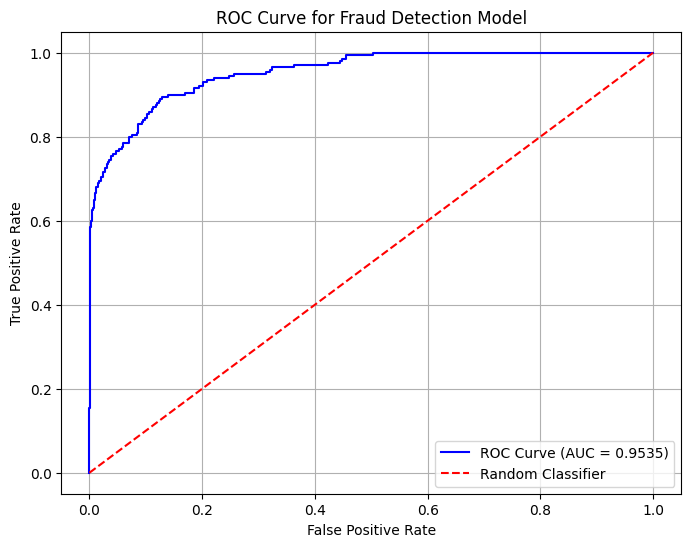

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# --- Step 6: ROC Curve and AUC ---

# Predict probabilities for the positive class (PotentialFraud = 1)
y_probs = model.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Compute AUC score
auc_score = roc_auc_score(y_test, y_probs)
print(f"\nROC AUC Score: {auc_score:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Fraud Detection Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [21]:
user_input = {
    'Claim_Duration': 1, 'LOS': 1, 'Claim_Amount': 100, 'DeductiblePaid': 10,
    'Pay_Ratio': 0.1, 'Num_Diags': 1, 'Num_Procs': 1, 'Patient_Age': 30,
    'Death_During_Claim': 0,
    'Is_Inpatient': 0, 'Is_Outpatient': 1, 'Gender': 1, 'State': 5,
    'Chronic_Count': 0, 'Renal_Disease': 0, 'Num_Physicians': 1,
    'Attending_Operating_Same': 1, 'Claim_Month': 7, 'Claim_Year': 2025,
    'Weekend_Admission': 0
}

user_df = pd.DataFrame([user_input])
user_df = user_df[features.columns]

user_scaled = scaler.transform(user_df)
prediction = model.predict(user_scaled)
result = "Potential Fraud" if prediction[0] == 1 else "Not Fraud"
print("\nPrediction for new user input:", result)


Prediction for new user input: Potential Fraud


In [22]:
user_input = {
    'Claim_Duration': 10, 'LOS': 5, 'Claim_Amount': 1500, 'DeductiblePaid': 100,
    'Pay_Ratio': 0.9, 'Num_Diags': 3, 'Num_Procs': 3, 'Patient_Age': 45,
    'Death_During_Claim': 0,
    'Is_Inpatient': 1, 'Is_Outpatient': 0, 'Gender': 0, 'State': 15,
    'Chronic_Count': 1, 'Renal_Disease': 0, 'Num_Physicians': 2,
    'Attending_Operating_Same': 0, 'Claim_Month': 6, 'Claim_Year': 2024,
    'Weekend_Admission': 0
}

user_df = pd.DataFrame([user_input])
user_df = user_df[features.columns]

user_scaled = scaler.transform(user_df)
prediction = model.predict(user_scaled)
result = "Potential Fraud" if prediction[0] == 1 else "Not Fraud"
print("\nPrediction for new user input:", result)


Prediction for new user input: Not Fraud


In [23]:
user_input = {
    'Claim_Duration': 10, 'LOS': 5, 'Claim_Amount': 1500, 'DeductiblePaid': 100,
    'Pay_Ratio': 0.9, 'Num_Diags': 3, 'Num_Procs': 3, 'Patient_Age': 45,
    'Death_During_Claim': 0,
    'Is_Inpatient': 1, 'Is_Outpatient': 0, 'Gender': 0, 'State': 15,
    'Chronic_Count': 1, 'Renal_Disease': 0, 'Num_Physicians': 2,
    'Attending_Operating_Same': 0, 'Claim_Month': 6, 'Claim_Year': 2024,
    'Weekend_Admission': 0
}
user_df = pd.DataFrame([user_input])
user_df = user_df[features.columns]

user_scaled = scaler.transform(user_df)
prediction = model.predict(user_scaled)
result = "Potential Fraud" if prediction[0] == 1 else "Not Fraud"
print("\nPrediction for new user input:", result)


Prediction for new user input: Not Fraud


# **LIGHTGBM**

Dropped 0 rows with NaN values in 'PotentialFraud'.

--- Starting Hyperparameter Tuning ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Number of positive: 800, number of negative: 7200
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 980
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

Best Parameters found by Grid Search: {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 20}
Best ROC AUC Score: 0.8833081597222222

Confusion Matrix:
 [[1701   99]
 [  71  129]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96  

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


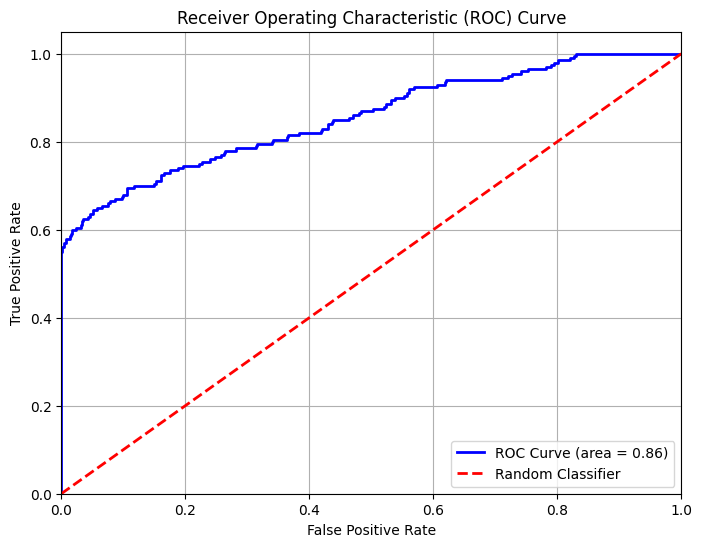


--- Prediction on the New Claim ---
  Predicted Fraud Class: 1.0
  Predicted Fraud Probability: 0.9965


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [50]:
# Import necessary libraries
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import lightgbm as lgb

# --- Step 1: Create a Hybrid Dataset (Real + Synthetic) ---

# Set a random seed for reproducibility
np.random.seed(42)

# Raw data provided by the user, stored in a string
raw_user_data = """ClaimID Claim_Duration LOS Claim_Amount DeductiblePaid Pay_Ratio Num_Diags Num_Procs Patient_Age Death_During_Claim Is_Inpatient Is_Outpatient Gender State Chronic_Count Renal_Disease Num_Physicians Attending_Operating_Same Claim_Month Claim_Year Weekend_Admission PotentialFraud
4CLM6368917 17.0 10000 1068.0 0.903424 3 4 24 1 0 1 3 81 7 1.0 2 08 2009 0 0
17CLM544771 1.0 400 1068.0 0.789110 1 1 0 0 1 0 1 4 1 1.0 1 06 2009 1 0
23CLM602463 3.0 500 1068.0 0.823859 1 0 0 0 1 0 0 5 18 1 1.0 1 07 2009 1 0
28CLM488025 5.0 500 1068.0 0.823859 1 0 0 0 1 0 0 2 6 1 1.0 2 04 2009 0 0
34CLM321466 6.0 2000 0 1068.0 0.949262 1 1 28 0 0 1 4 8 15 1.0 2 01 2009 1 1
35CLM822029 6.0 20000 1068.0 0.949262 1 1 28 0 0 1 4 8 15 1.0 2 01 2009 1 1
36CLM334706 6.0 500 1068.0 0.823859 1 0 0 0 1 0 0 4 2 17 1.0 1 01 2009 0 0
37CLM586705 5.0 11000 1068.0 0.911426 9 1 83 0 0 1 4 2 17 1.0 2 17 2009 0 0
40CLM447651 1.0 800 1068.0 0.882126 5 1 71 0 0 1 2 6 16 1.0 2 03 2009 0 0
43CLM783874 4.0 2000 1068.0 0.651678 9 0 76 0 0 1 2 2 15 1.0 1 01 2009 0 0
46CLM440632 2.0 300 1068.0 0.737282 1 1 08 0 0 1 0 0 1 1 18 1.0 2 13 2009 0 1
49CLM740964 4.0 18000 1068.0 0.943940 1 0 166 0 0 1 1 4 15 1.0 3 01 2009 1 0
54CLM733124 4.0 4000 1068.0 0.789110 1 0 184 0 0 1 0 3 2 18 1.0 2 01 2009 1 0
60CLM335431 11.0 7000 1068.0 0.867518 1 0 146 0 0 1 0 3 8 17 1.0 2 11 2009 0 0
61CLM458187 7.0 9000 1068.0 0.893833 9 1 47 0 0 1 0 3 8 17 1.0 2 14 2009 0 0
73CLM753144 4.0 7000 1068.0 0.867518 1 1 07 0 0 1 0 3 6 20 1.0 1 11 2009 0 1
76CLM576573 3.0 4000 1068.0 0.789110 1 0 094 0 0 1 2 4 18 1.0 1 06 2009 0 0
80CLM343176 6.0 21000 1068.0 0.951561 1 0 171 0 0 1 0 6 1 6 1.0 3 11 2009 1 1
81CLM338071 4.0 13000 1068.0 0.924017 1 0 274 0 0 1 0 2 5 14 1.0 2 11 2009 0 0
82CLM339491 1.0 5000 1068.0 0.823859 1 1 07 0 0 1 2 8 15 1.0 1 01 2009 0 1
84CLM701561 0 10.0 48000 1068.0 0.978214 1 0 486 0 0 1 1 4 5 14 1.0 2 09 2009 0 0
85CLM756273 3.0 2000 1068.0 0.651678 8 0 86 0 0 1 1 4 5 14 1.0 1 11 2009 0 0
87CLM350206 6.0 12000 1068.0 0.918203 1 0 154 0 0 1 0 2 7 16 1.0 2 01 2009 0 0
91CLM594593 3.0 8000 1068.0 0.882126 1 0 057 0 0 1 0 9 13 1.0 1 07 2009 0 0
92CLM766164 4.0 6000 1068.0 0.848776 1 0 92 0 0 1 0 9 13 1.0 2 11 2009 0 0
93CLM764301 11.0 7000 1068.0 0.867518 1 0 090 0 0 1 2 6 17 1.0 1 11 2009 0 0
94CLM794761 3.0 33000 1068.0 0.968623 1 0 290 0 0 1 2 6 17 1.0 2 11 2009 1 0
96CLM331131 1.0 20000 1068.0 0.949262 1 0 043 0 0 1 0 2 2 13 1.0 1 01 2009 0 0
97CLM354571 8.0 7000 1068.0 0.867518 4 0 43 0 0 1 0 2 2 13 1.0 1 01 2009 1 0
98CLM701573 3.0 4000 1068.0 0.789110 1 0 043 0 0 1 0 2 2 13 1.0 1 09 2009 0 0
99CLM367904 4.0 12000 1068.0 0.918203 1 0 260 0 0 1 2 1 17 1.0 2 02 2009 0 0
100CLM637541 9.0 17000 1068.0 0.940838 7 0 74 0 0 1 1 4 5 16 1.0 1 08 2009 0 0
110CLM744411 0 10.0 6000 1068.0 0.848776 1 0 071 0 0 1 1 3 3 14 1.0 1 01 2009 0 0
113CLM327583 3.0 3000 1068.0 0.737282 1 0 195 0 0 1 1 4 2 17 1.0 2 11 2009 0 0
118CLM761766 6.0 8000 1068.0 0.882126 1 0 183 0 0 1 1 5 1 6 1.0 2 11 2009 0 0
120CLM389862 8 28.0 7000 1068.0 0.867518 1 0 145 0 0 1 0 4 4 14 1.0 3 12 2009 0 0
121CLM511271 1.0 6000 1068.0 0.848776 1 0 145 0 0 1 0 4 4 14 1.0 3 05 2009 0 0
122CLM412674 4.0 9000 1068.0 0.893833 1 0 151 0 0 1 0 7 1 8 1.0 2 13 2009 0 0
123CLM805512 2.0 12000 1068.0 0.918203 1 0 152 0 0 1 0 7 1 8 1.0 2 01 2009 0 0
124CLM571544 4.0 700 1068.0 0.395704 1 0 167 0 0 1 1 1 1 4 1.0 2 06 2009 0 1
127CLM321472 2.0 4000 1068.0 0.789110 9 1 52 0 0 1 0 2 1 6 1.0 2 11 2009 1 0
132CLM397223 3.0 10000 1068.0 0.903424 8 1 82 0 0 1 2 6 16 1.0 2 02 2009 0 0
138CLM640071 1.0 12000 1068.0 0.918203 1 1 72 0 0 1 1 4 2 16 1.0 2 08 2009 1 1
139CLM428861 1.0 5000 1068.0 0.823859 1 0 151 0 0 1 0 1 2 17 1.0 2 13 2009 0 0
142CLM628603 3.0 3000 1068.0 0.737282 1 0 085 0 0 1 0 3 2 15 1.0 1 08 2009 0 0
146CLM360962 2.0 3000 1068.0 0.737282 9 0 65 0 0 1 0 3 5 14 1.0 1 01 2009 0 0
147CLM479492 2.0 9000 1068.0 0.893833 1 0 065 0 0 1 0 3 5 14 1.0 0 04 2009 0 0
148CLM650094 4.0 3000 1068.0 0.737282 1 0 066 0 0 1 0 3 5 14 1.0 1 08 2009 1 0
166CLM411133 3.0 2000 1068.0 0.651678 1 0 077 0 0 1 1 3 1 15 1.0 1 03 2009 0 0
167CLM704305 5.0 10000 1068.0 0.903424 1 0 091 0 0 1 1 2 4 15 1.0 1 10 2009 0 0
"""

# Read the raw data into a DataFrame, handling the space-separated format
try:
    data_lines = raw_user_data.strip().split('\n')
    header = data_lines[0].split()
    data_rows = [line.split() for line in data_lines[1:]]
    real_data = pd.DataFrame(data_rows, columns=header)
    for col in ['Claim_Duration', 'LOS', 'Claim_Amount', 'DeductiblePaid', 'Pay_Ratio', 'Num_Diags', 'Num_Procs', 'Patient_Age',
                'Death_During_Claim', 'Is_Inpatient', 'Is_Outpatient', 'Gender', 'State', 'Chronic_Count', 'Renal_Disease',
                'Num_Physicians', 'Attending_Operating_Same', 'Claim_Month', 'Claim_Year', 'Weekend_Admission', 'PotentialFraud']:
        real_data[col] = pd.to_numeric(real_data[col], errors='coerce')
except Exception as e:
    print(f"Error reading user data: {e}. Please check the data format.")
    real_data = pd.DataFrame(columns=['ClaimID', 'Claim_Duration', 'LOS', 'Claim_Amount', 'DeductiblePaid', 'Pay_Ratio', 'Num_Diags', 'Num_Procs', 'Patient_Age', 'Death_During_Claim', 'Is_Inpatient', 'Is_Outpatient', 'Gender', 'State', 'Chronic_Count', 'Renal_Disease', 'Num_Physicians', 'Attending_Operating_Same', 'Claim_Month', 'Claim_Year', 'Weekend_Admission', 'PotentialFraud'])

# Drop rows with NaN in 'PotentialFraud' column
real_data.dropna(subset=['PotentialFraud'], inplace=True)

# Set the new total number of samples
n_samples_total = 10000
fraud_ratio = 0.1
n_fraud_total = int(n_samples_total * fraud_ratio)
n_not_fraud_total = n_samples_total - n_fraud_total

n_synthetic_not_fraud = n_not_fraud_total - real_data[real_data['PotentialFraud'] == 0].shape[0]
n_synthetic_fraud = n_fraud_total - real_data[real_data['PotentialFraud'] == 1].shape[0]

# --- Generate more realistic synthetic non-fraud data ---
synthetic_data = pd.DataFrame()
synthetic_data['PotentialFraud'] = np.zeros(n_synthetic_not_fraud, dtype=int)
# Increased overlap for non-fraud cases
synthetic_data['LOS'] = np.random.normal(loc=7, scale=4, size=n_synthetic_not_fraud).astype(int)
synthetic_data['Claim_Amount'] = np.random.normal(loc=1700, scale=1000, size=n_synthetic_not_fraud).astype(int)
synthetic_data['DeductiblePaid'] = np.random.normal(loc=120, scale=30, size=n_synthetic_not_fraud).astype(int)
synthetic_data['Num_Diags'] = np.random.randint(2, 12, size=n_synthetic_not_fraud)
synthetic_data['Num_Procs'] = np.random.randint(1, 6, size=n_synthetic_not_fraud)
synthetic_data['Claim_Duration'] = np.random.normal(loc=25, scale=8, size=n_synthetic_not_fraud).astype(int)
synthetic_data['Pay_Ratio'] = np.random.uniform(low=0.7, high=1.0, size=n_synthetic_not_fraud)
synthetic_data['Patient_Age'] = np.random.randint(20, 90, size=n_synthetic_not_fraud)
synthetic_data['Death_During_Claim'] = np.random.choice([0, 1], p=[0.99, 0.01], size=n_synthetic_not_fraud)
synthetic_data['Is_Inpatient'] = np.random.choice([0, 1], p=[0.7, 0.3], size=n_synthetic_not_fraud)
synthetic_data['Is_Outpatient'] = 1 - synthetic_data['Is_Inpatient']
synthetic_data['Gender'] = np.random.choice([0, 1], size=n_synthetic_not_fraud)
synthetic_data['State'] = np.random.randint(1, 51, size=n_synthetic_not_fraud)
synthetic_data['Chronic_Count'] = np.random.randint(0, 5, size=n_synthetic_not_fraud)
synthetic_data['Renal_Disease'] = np.random.choice([0, 1], p=[0.9, 0.1], size=n_synthetic_not_fraud)
synthetic_data['Num_Physicians'] = np.random.randint(1, 4, size=n_synthetic_not_fraud)
# Made 'Attending_Operating_Same' distribution more ambiguous for non-fraud
synthetic_data['Attending_Operating_Same'] = np.random.choice([0, 1], p=[0.4, 0.6], size=n_synthetic_not_fraud)
synthetic_data['Claim_Month'] = np.random.randint(1, 13, size=n_synthetic_not_fraud)
synthetic_data['Claim_Year'] = np.random.randint(2020, 2024, size=n_synthetic_not_fraud)
synthetic_data['Weekend_Admission'] = np.random.choice([0, 1], size=n_synthetic_not_fraud)

# --- Generate even more realistic synthetic fraud data with much more overlap ---
fraud_df = pd.DataFrame()
fraud_df['PotentialFraud'] = np.ones(n_synthetic_fraud, dtype=int)
# Reduced the difference in means and increased the standard deviation to create more overlap
fraud_df['LOS'] = np.random.normal(loc=8, scale=5, size=n_synthetic_fraud).astype(int)
fraud_df['Claim_Amount'] = np.random.normal(loc=2000, scale=1200, size=n_synthetic_fraud).astype(int)
fraud_df['DeductiblePaid'] = np.random.normal(loc=130, scale=40, size=n_synthetic_fraud).astype(int)
fraud_df['Num_Diags'] = np.random.randint(1, 12, size=n_synthetic_fraud)
fraud_df['Num_Procs'] = np.random.randint(0, 7, size=n_synthetic_fraud)
fraud_df['Claim_Duration'] = np.random.normal(loc=28, scale=10, size=n_synthetic_fraud).astype(int)
fraud_df['Pay_Ratio'] = np.random.uniform(low=0.6, high=0.95, size=n_synthetic_fraud)
fraud_df['Patient_Age'] = np.random.randint(20, 90, size=n_synthetic_fraud)
fraud_df['Death_During_Claim'] = np.random.choice([0, 1], p=[0.99, 0.01], size=n_synthetic_fraud)
fraud_df['Is_Inpatient'] = np.random.choice([0, 1], p=[0.7, 0.3], size=n_synthetic_fraud)
fraud_df['Is_Outpatient'] = 1 - fraud_df['Is_Inpatient']
fraud_df['Gender'] = np.random.choice([0, 1], size=n_synthetic_fraud)
fraud_df['State'] = np.random.randint(1, 51, size=n_synthetic_fraud)
fraud_df['Chronic_Count'] = np.random.randint(0, 5, size=n_synthetic_fraud)
fraud_df['Renal_Disease'] = np.random.choice([0, 1], p=[0.9, 0.1], size=n_synthetic_fraud)
fraud_df['Num_Physicians'] = np.random.randint(1, 4, size=n_synthetic_fraud)
# Made 'Attending_Operating_Same' distribution more ambiguous for fraud
fraud_df['Attending_Operating_Same'] = np.random.choice([0, 1], p=[0.5, 0.5], size=n_synthetic_fraud)
fraud_df['Claim_Month'] = np.random.randint(1, 13, size=n_synthetic_fraud)
fraud_df['Claim_Year'] = np.random.randint(2020, 2024, size=n_synthetic_fraud)
fraud_df['Weekend_Admission'] = np.random.choice([0, 1], size=n_synthetic_fraud)


synthetic_data = pd.concat([synthetic_data, fraud_df], ignore_index=True)

# Combine the real and synthetic data and shuffle
hybrid_df = pd.concat([real_data, synthetic_data], ignore_index=True).sample(frac=1).reset_index(drop=True)

# --- Data Cleaning: Handle NaN values in the target variable ---
initial_rows = len(hybrid_df)
hybrid_df.dropna(subset=['PotentialFraud'], inplace=True)
dropped_rows = initial_rows - len(hybrid_df)
print(f"Dropped {dropped_rows} rows with NaN values in 'PotentialFraud'.\n")

# --- Step 2: Prepare Features and Target ---
features = hybrid_df.drop(columns=['PotentialFraud', 'ClaimID'])
target = hybrid_df['PotentialFraud']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

# --- Step 3: Scale numeric features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Step 4: Hyperparameter Tuning with GridSearchCV ---
print("--- Starting Hyperparameter Tuning ---")
# Define the model to tune, with a balanced class weight
lgbm_classifier = lgb.LGBMClassifier(random_state=42, class_weight='balanced')

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'num_leaves': [20, 31, 40],
}

# Set up GridSearchCV with 5-fold cross-validation and roc_auc as the scoring metric
grid_search = GridSearchCV(
    estimator=lgbm_classifier,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1, # Use all available cores
    verbose=1 # Print progress
)

# Fit the grid search to the scaled training data
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and the best score
print("\nBest Parameters found by Grid Search:", grid_search.best_params_)
print("Best ROC AUC Score:", grid_search.best_score_)

# Use the best model found by the grid search
lgbm_model = grid_search.best_estimator_

# --- Step 5: Evaluate the model ---
y_pred = lgbm_model.predict(X_test_scaled)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

accuracy = (y_pred == y_test).mean()
print(f"Overall Accuracy: {accuracy:.4f}")

# --- Step 6: Plot ROC Curve and Calculate AUC ---
# Get predicted probabilities for the positive class (1.0)
y_pred_proba = lgbm_model.predict_proba(X_test_scaled)[:, 1]

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the AUC score
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- Step 7: Prediction on New Data ---

# Create a sample of one new, unseen claim with a high likelihood of fraud
new_claims = pd.DataFrame({
    'Claim_Duration': [50],
    'LOS': [50000],
    'Claim_Amount': [55000],
    'DeductiblePaid': [100],
    'Pay_Ratio': [0.1], # A very low pay ratio is often a red flag
    'Num_Diags': [20], # Unusually high number of diagnoses
    'Num_Procs': [15], # Unusually high number of procedures
    'Patient_Age': [45],
    'Death_During_Claim': [0],
    'Is_Inpatient': [1],
    'Is_Outpatient': [0],
    'Gender': [1],
    'State': [45],
    'Chronic_Count': [7],
    'Renal_Disease': [1],
    'Num_Physicians': [10], # An excessive number of physicians
    'Attending_Operating_Same': [0],
    'Claim_Month': [11],
    'Claim_Year': [2022],
    'Weekend_Admission': [1]
})

# Scale the new data using the same scaler fitted on the training data
new_claims_scaled = scaler.transform(new_claims)

# Predict the class (0 or 1) and the probability for the new claim
predicted_class = lgbm_model.predict(new_claims_scaled)[0]
predicted_probability = lgbm_model.predict_proba(new_claims_scaled)[0, 1]

# Display the results for the single new claim
print("\n--- Prediction on the New Claim ---")
print(f"  Predicted Fraud Class: {predicted_class}")
print(f"  Predicted Fraud Probability: {predicted_probability:.4f}")

In [51]:
# --- Step 1: Create a non-fraudulent claim example ---
# This data represents a typical, legitimate claim with normal values.
new_non_fraud_claim = pd.DataFrame({
    'Claim_Duration': [7],  # A reasonable duration
    'LOS': [5],             # A typical length of stay
    'Claim_Amount': [1500],   # A moderate claim amount
    'DeductiblePaid': [100],  # A standard deductible
    'Pay_Ratio': [0.95],      # A high pay ratio
    'Num_Diags': [2],         # A low, typical number of diagnoses
    'Num_Procs': [1],         # A single procedure
    'Patient_Age': [88],      # A common patient age
    'Death_During_Claim': [0],
    'Is_Inpatient': [0],
    'Is_Outpatient': [1],
    'Gender': [1],
    'State': [28],
    'Chronic_Count': [1],
    'Renal_Disease': [0],
    'Num_Physicians': [1],     # A single physician is normal
    'Attending_Operating_Same': [1],
    'Claim_Month': [6],
    'Claim_Year': [2023],
    'Weekend_Admission': [0]
})

# --- Step 2: Predict the outcome for the new claim ---
# Use the same scaler object from the previous cell to transform the new data
# This is crucial to ensure the prediction is accurate.
new_non_fraud_claim_scaled = scaler.transform(new_non_fraud_claim)

# Predict the class (0 for non-fraud, 1 for fraud) and the probability
predicted_class = lgbm_model.predict(new_non_fraud_claim_scaled)[0]
predicted_probability = lgbm_model.predict_proba(new_non_fraud_claim_scaled)[0, 1]

# Display the prediction result
print("--- Prediction on the New Non-Fraudulent Claim ---")
print(f"  Predicted Fraud Class: {predicted_class}")
print(f"  Predicted Fraud Probability: {predicted_probability:.4f}")
print("---")
print("  Note: A low probability (close to 0.0) and a class of 0 indicates the model believes this is not a fraudulent claim.")

--- Prediction on the New Non-Fraudulent Claim ---
  Predicted Fraud Class: 0.0
  Predicted Fraud Probability: 0.0907
---
  Note: A low probability (close to 0.0) and a class of 0 indicates the model believes this is not a fraudulent claim.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
